In [29]:
from astropy.io import fits 
import pandas as pd 
import numpy as np
import umap
import matplotlib.pyplot as plt 
#import smplotlib

In [2]:
df = pd.read_csv('/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/QSO_DR16_catalogue.csv')

plates, mjds, fiberids = df['plate'], df['mjd'], df['fiberid']

def download_qso_spectra(plates, mjds, fiberids, download_dir:str, output_file:str=None):
    import os 

    commands = []

    for i in range(len(plates)):
        plate = str(plates[i])
        mjd = str(mjds[i])
        fiberid = str(fiberids[i])
        fiberid = f"{(4-len(fiberid))*'0'}{fiberid}"
        link = f'https://dr18.sdss.org/sas/dr18/prior-surveys/sdss4-dr17-eboss/spectro/redux/v5_13_2/spectra/lite/{plate}/spec-{plate}-{mjd}-{fiberid}.fits'

        plate_dir = os.path.join(download_dir, plate)

        command = f'wget {link} --directory-prefix="{plate_dir}" -q'

        if output_file is None: 
             
            print(command)

        else: 
            commands.append(command)

    with open(output_file, 'w') as f: 
        for command in commands: 
            f.write(command+'\n')

download_dir = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra'
output_file = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/code/monthly/mar2024/wk4/qso-umap/download.sh'
download_qso_spectra(plates[450:].to_list(), mjds[450:].to_list(), fiberids[450:].to_list(), download_dir=download_dir, output_file=output_file)
#https://dr18.sdss.org/sas/dr18/prior-surveys/sdss4-dr17-eboss/spectro/redux/v5_13_2/spectra/lite/10227/spec-10227-58224-0001.fits
#https://dr18.sdss.org/sas/dr18/prior-surveys/sdss4-dr17-eboss/spectro/redux/v5_13_2/spectra/lite/7596/spec-7596-56945-0162.fits

# note

server is not working, so here are some links to resume from later: 
https://data.sdss.org/sas/dr17/eboss/spectro/redux/v5_13_2/spectra 
https://www.sdss4.org/surveys/eboss/
https://www.sdss4.org/dr17/algorithms/qso_catalog_dr14 
https://www.sdss4.org/dr17/algorithms/qso_catalog/ 


command to run sh file: 
sh "/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/code/monthly/mar2024/wk4/qso-umap/download.sh" > log.txt 2>&1 &
# [1] 8346

In [19]:
import torch
import pandas as pd 
from spender.data.sdss import SDSS, BOSS
import os 

github = "pmelchior/spender"
sdss, model = torch.hub.load(github, 'sdss_II', map_location=torch.device('cpu'))

data_path = "/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra"

df = pd.read_csv('/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/QSO_DR16_catalogue.csv', dtype = object)

#plates, mjds, fiberids = df['plate'], df['mjd'], df['fiberid']
plates = []
mjds = []
fiberids = []

#ids = ((412, 52254, 308), (412, 52250, 129))

dir = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra'
for sub_dir in os.listdir(dir): 
    sub_dir = os.path.join(dir, sub_dir)
    for file in os.listdir(sub_dir): 
        if '.1' not in file: 
            file_list = file.split('-')
            plates.append(int(file_list[1]))
            mjds.append(int(file_list[2]))
            fiberids.append(int(file_list[3].split('.')[0]))

ids = list((plates[i], mjds[i], fiberids[i]) for i in range(len(plates)))
print((len(fiberids)))
spec, w, z, norm, zerr = BOSS.make_batch(data_path, ids)

# only encode into latents
with torch.no_grad():
    s = model.encode(spec)

Using cache found in /Users/yaroslav/.cache/torch/hub/pmelchior_spender_main


5023


In [23]:
#latents = s.numpy() 
latent_space = s.numpy()
latent_space = latent_space[~np.isnan(latent_space).any(axis=1)]

for i in latent_space: 
    print(i)

[ 0.4815742   0.11025886 -0.13731535 -0.6348152  -0.27510056  0.18237746]
[ 1.1524128   0.12771127 -1.0589172  -1.6942788  -1.1308339   1.1566179 ]
[ 0.775108    0.2139248  -0.43375003 -1.1423905  -0.60662335  0.522282  ]
[ 0.69755185  0.3191505  -0.10898109 -1.168087   -0.28922716  0.44344977]
[ 1.0594369   0.26971638 -0.8643007  -1.6980925  -0.8315943   0.9525826 ]
[ 0.81647646  0.04926518 -0.70394915 -0.9720277  -0.6672557   0.6439728 ]
[ 0.7886425   0.27226263 -0.47036463 -1.2099489  -0.69125926  0.5485033 ]
[ 1.2408675   0.34102878 -1.1735613  -2.1827705  -1.1081672   1.3970201 ]
[ 0.87254876  0.02247195 -0.7178891  -1.1269861  -0.81175816  0.7790731 ]
[ 0.49435806  0.215022   -0.05390929 -0.709348   -0.31099913  0.21434379]
[ 1.0072935   0.1642412  -0.86142737 -1.588641   -0.8672268   0.96708876]
[ 1.0526338   0.57875764 -0.8835579  -2.1405582  -0.8087117   1.2109905 ]
[ 1.1196389   0.5655225  -0.7144105  -2.132458   -0.95455104  0.984314  ]
[ 0.79850143  0.22416294 -0.5154079  -

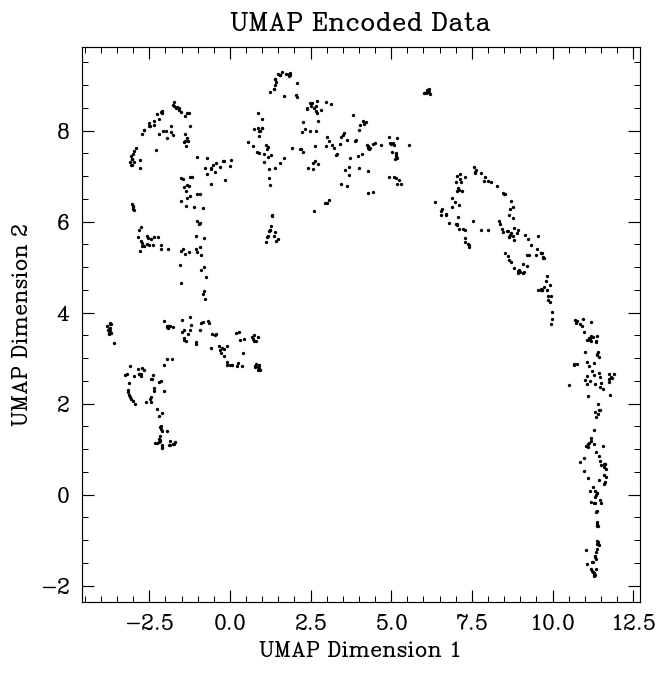

In [39]:
reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(latent_space)

# Plot the Reduced Data 

umap_x = reduced_data[:, 0]
umap_y = reduced_data[:, 1]

z_values = z.numpy()
z_values = z_values[0:5023]
z_values = z_values[~np.isnan(s.numpy()).any(axis=1)]

plt.scatter(umap_x, umap_y, s=1, color='black')
plt.title("UMAP Encoded Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [21]:
# log10(h alpha) --> log10(halpha)
# z 
# log10(mass) --> LOGMBH
# log10(eddington ratio) --> LOGLEDD_RATIO 

In [ ]:
colors = []
color_labels = ['log10(halpha)', 'z', 'log10(BH mass)', 'log10(eddington ratio)']


for i in range(4):
    fig, ax = plt.subplots()

    cmap = ax.scatter(umap_x, umap_y, s=2, color=colors[i])
    ax.set(title=color_labels[i])
    ax.set_axis_off()
    
    fig.colorbar(cmap, orientation="horizontal", pad=0.1)

    plt.show()
    plt.clf()

